
Neural networks are known to "trick" us by exploiting unobvious shortcuts (e.g. learning type of terrain  instead of features of dogs and wolves) leading to good performance. Convolutional Neural Networks (CNN) are extremely useful in image classification tasks. They recognize patterns in the data by encoding various features in the images such as edges, lines, circles.
We hope a neural network to depend solely on pixels it sees, but... position information might be useful as well.

Can a CNN encode positional information using padding? In this task, you will verify this hypothesis.

You have to implement a CNN model which will encode a positional information spectrum using convolutional layers. Input to the network is noise from normal distribution and target is a spectrum ranging $[0,1]$.



In [ ]:
import torch.nn.functional as F
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim
import numpy as np
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cpu


# Implement SimpleConvnet
This model consist of two parts:
- a parametrized number of blocks
- linear projection

Each block should have two layers: *convolution* and *relu*. The number of blocks is parametrized by the **n_convolutions** argument. All convolutions layers **in blocks** should have a kernel_size equal to 3 and padding equal to 1.

The input to the model has the shape: (batch_size, 1, x.shape[-2], x.shape[-1]), so it starts with only 1 channel. First 4 blocks should double the number of channels. Blocks from index 4 upward should keep the number of channels unchanged.

Linear projection should decrease the number of channels to 1. Therefore, the output of the model should match the input in shape.

In [ ]:
class SimpleConvnet(nn.Module):
    def __init__(self, n_convolutions):
        super(SimpleConvnet, self).__init__()
        # TODO
        k = 4
        layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(
                in_channels = 2**i if i < k else 2**k,
                out_channels= 2**(i+1)if i < 4 else 2**k,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU()) for i in range(n_convolutions)])
        self.convolutions = nn.Sequential(*layers)

        end_channels = 2**n_convolutions if n_convolutions < k else 2**k
        self.projection = nn.Conv2d(end_channels, 1, 1, 1, 0)
        # END TODO


    def forward(self, x):
      # TODO
      x = self.convolutions(x)
      return self.projection(x)
      # END TODO


## Helper functions

In [ ]:
def visualize(array):
  plt.figure(figsize=(2,2))
  sns.set(font_scale=0.7)
  sns.heatmap(array, cmap='viridis', cbar=False, annot=False)
  plt.show()

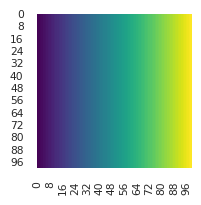

In [ ]:
def generate_spectrum(spatial_dimension):
  row = torch.linspace(0, 1, spatial_dimension)
  return row.expand(spatial_dimension, -1)
spectrum = generate_spectrum(100)
visualize(spectrum.numpy())

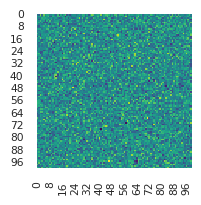

In [ ]:
def generate_noise(batch_size, spatial_dimension):
  return torch.randn(batch_size, 1, spatial_dimension, spatial_dimension)
visualize(generate_noise(1,100)[0].squeeze().numpy())

## Training
Implement target generation.

In [ ]:

def train(epochs, steps, batch_size, model, optimizer, spatial_dimension, verbose=1):
    model.train()
    train_start = time.time()

    # TODO
    # Prepare target (it will be the same in every example)
    target_gradient = generate_spectrum(spatial_dimension) #.unsqueeze(0).unsqueeze(1)
    target_gradient = target_gradient[None, None, ...]
    target = target_gradient.expand(batch_size, 1, spatial_dimension, spatial_dimension)
    # ENDTODO
    assert target.shape == torch.Size([batch_size, 1, spatial_dimension, spatial_dimension])

    for epoch in range(epochs):
        epoch_start_time = time.time()
        running_loss = 0
        for i in range(steps):
            step_start_time = time.time()
            noise = generate_noise(batch_size, spatial_dimension)
            predicted = model(noise)
            loss = F.mse_loss(predicted, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if verbose >= 2:
                print("Step: {:.2f} seconds".format(time.time()-step_start_time))

        if verbose >= 3:
          print('Epoch [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, epochs, running_loss / steps))
          with torch.no_grad():
            input = generate_noise(1, spatial_dimension)
            predicted_gradient = model(input)[0].numpy()
            visualize(predicted_gradient.squeeze(0))
        if verbose >= 1:
          print("Epoch: {:.2f} seconds".format(time.time()-epoch_start_time))

    if verbose >= 0:
        print("Training spatial_dim{}: {:.2f} seconds".format(spatial_dimension,time.time()-train_start))


In [ ]:
# Test training
# Expertiment with different values
# do not exceed n_convolutions = 10 and spatial_dimension = 20
n_convolutions = # TODO
spatial_dimension = # TODO
epochs = 20
steps = 50

model = SimpleConvnet(n_convolutions)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(epochs=20, steps=100, batch_size=256, model=model, optimizer=optimizer, spatial_dimension=spatial_dimension, verbose=3)

## Experiments

Create two lists:
- *n_convolutions_params* with 4 different values
- *spatial_dimensions_params* with 4 different values

For each pair (n_convolutions,spatial_dimensions) $\in$ (n_convolutions_params $\times$ spatial_dimensions_param), train a model with these parameters and visualize the prediction of the trained model on a sampled noise.

Represent these vizualizations on image grid of size (4 $\times$ 4). Explain these results.

(Note: do not exceed n_convolutions = 10 and spatial_dimension = 20. It takes about 2min on CPU to train model with these parameters. )

(Note2: *visualize* function runs plt.show() so it can interfere with image grid. You can disable it by changing verbose argument in *train* to 0.)


Training spatial_dim5: 1.47 seconds
Training spatial_dim10: 2.56 seconds
Training spatial_dim15: 4.27 seconds
Training spatial_dim20: 6.87 seconds
Training spatial_dim5: 2.21 seconds
Training spatial_dim10: 4.83 seconds
Training spatial_dim15: 9.31 seconds
Training spatial_dim20: 13.11 seconds
Training spatial_dim5: 4.52 seconds
Training spatial_dim10: 12.05 seconds
Training spatial_dim15: 23.04 seconds
Training spatial_dim20: 37.69 seconds
Training spatial_dim5: 12.60 seconds
Training spatial_dim10: 38.43 seconds
Training spatial_dim15: 79.06 seconds
Training spatial_dim20: 136.34 seconds


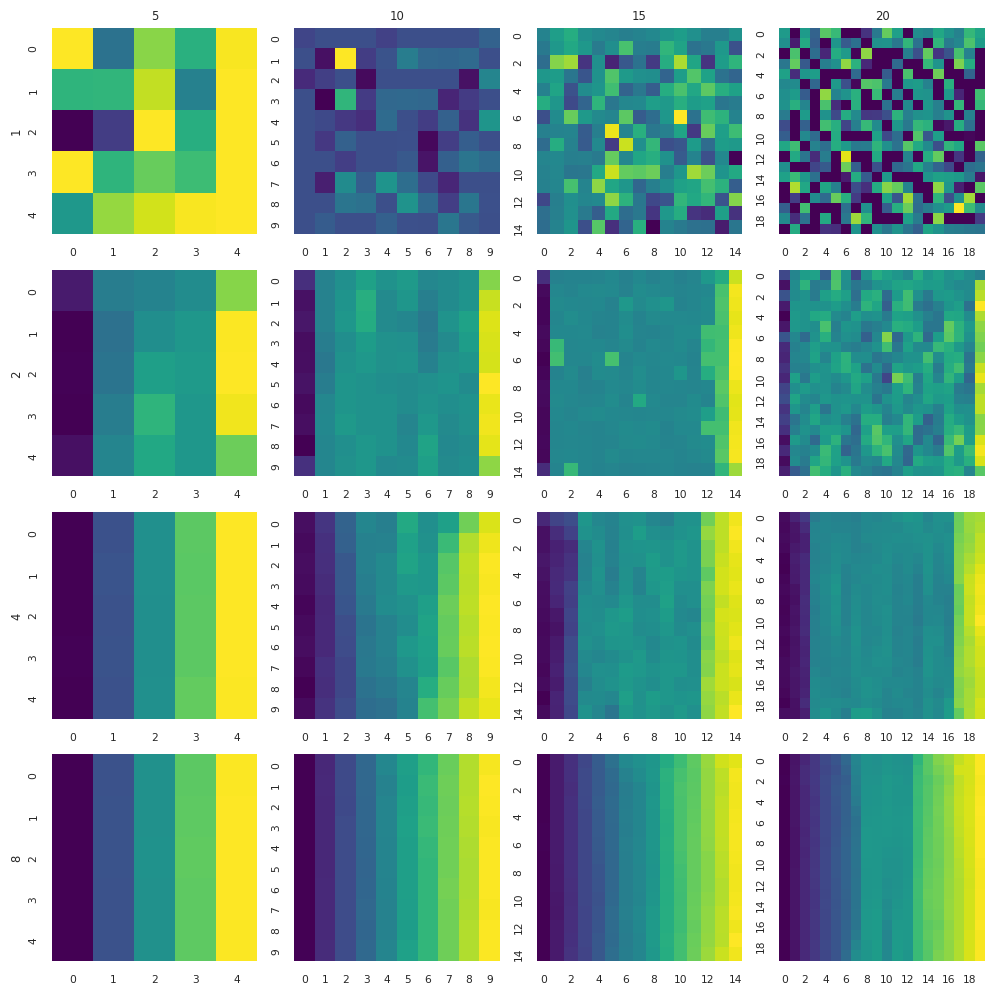

In [ ]:
#TODO
n_convolutions_sizes = [1,2,4,8]
spatial_dimensions = [5,10,15,20]
fig, axes = plt.subplots(len(n_convolutions_sizes), len(spatial_dimensions), figsize=(10, 10))

for i, n_convolutions in enumerate(n_convolutions_sizes):
    for j, dim in enumerate(spatial_dimensions):
        model = SimpleConvnet(n_convolutions)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        train(epochs=20, steps=50, batch_size=256, model=model, optimizer=optimizer, spatial_dimension=dim, verbose=0)
        noise = generate_noise(1, dim)
        output = model(noise)[0].detach().numpy().squeeze()
        ax = axes[i, j]
        sns.heatmap(output, ax=ax, cmap='viridis', cbar=False, annot=False)

        if j == 0:
            ax.set_ylabel(n_convolutions)
        if i == 0:
            ax.set_title(dim)

plt.tight_layout()
plt.show()
# END TODO